In [1]:
# imports
import math
import numpy as np
# from Vision import Vision
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [3]:
## TEST CELL
# a = [[ 11,  21,  31,  41,  51,  61,  71],
#       [ 12,  22,  32,  42,  52,  62,  72],
#       [ 13,  23,  33,  43,  53,  63,  73],
#       [ 14,  24,  34,  44,  54,  64,  74],
#       [ 15,  25,  35,  45,  55,  65,  75],
#       [ 16,  26,  36,  46,  56,  66,  76],
#       [ 17,  27,  37,  47,  57,  67,  77]]

# def neighbors(radius, row_number, column_number):
#      return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
#                 for j in range(column_number-1-radius, column_number+radius)]
#                     for i in range(row_number-1-radius, row_number+radius)]

# F = neighbors(2,4,3)
# print(F)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


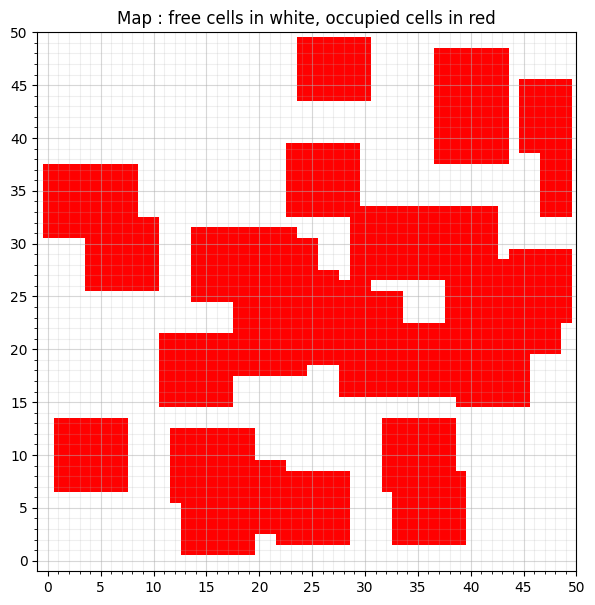

In [47]:
SIZE_MAP = 50
SIZE_SQUARE = 2 # centimeters
SIZE_THYMIO = 11.2 # centimeters
RADIUS = math.floor(SIZE_THYMIO/(2*SIZE_SQUARE)) + 1 

fig, ax = create_empty_plot(SIZE_MAP)
# number of squares not to use in the algorithm for the Thymio to stay out of the fixed obstacles

# class Global_Nav:
#     def __init__(self, start, end):
#         self.start = start
#         self.end = end
#         self.size_map = SIZE_MAP
#         self.radius = RADIUS
        
def neighbors(radius, row_number, column_number, occupancy_grid):
    """
    Function returning a matrix of the neighbouring squares 
    
    
    """
    return np.matrix([[occupancy_grid[i][j] if  i >= 0 and i < len(occupancy_grid) and j >= 0 and j < len(occupancy_grid[0]) else 0
                for j in range(column_number-1-radius, column_number+radius)]
                    for i in range(row_number-1-radius, row_number+radius)])


# np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(SIZE_MAP, SIZE_MAP) * 20 # change to get it from vision -
cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

def grid_occupancy():
    limit = 19.7 
    occupancy_grid = data.copy()
    occupancy_grid[data>limit] = 1
    occupancy_grid[data<=limit] = 0
    occupancy_neighbors = occupancy_grid.copy()
    for i in range(SIZE_MAP):
        for j in range(SIZE_MAP):
            sum_obstacles = np.matrix.sum(neighbors(RADIUS, i, j, occupancy_grid))
            if sum_obstacles != 0:
                occupancy_neighbors[i,j] = 1
    return occupancy_neighbors

occupancy_grid = grid_occupancy()


print(occupancy_grid)
# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


In [42]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]


def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]


def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N", max_val=SIZE_MAP):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet    

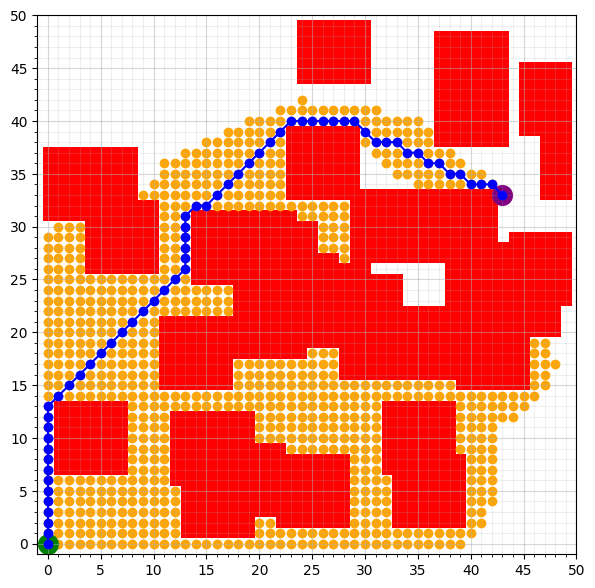

In [48]:
# Define the start and end goal
start = (0,0)
goal = (43,33)



# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:SIZE_MAP:1, 0:SIZE_MAP:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(SIZE_MAP)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);